In [1]:
import tifffile as tf
from scipy import ndimage, signal

import numpy as np
import pandas as pd
import os

import glob
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import walnut_utils as wnut

In [2]:
ang = np.linspace(0, 2*np.pi, 200, endpoint=True)
circle = np.vstack((np.sin(ang), np.cos(ang)))

In [3]:
src = '../hpcc/'
dst = '../hpcc/kernel/'

wsrc = src + 'clean/'
tsrc = src + 'watershed/'
rsrc = src + 'rotated/'

fs = 15
resol = 0.0759

mborder = ndimage.generate_binary_structure(3, 1).astype(int)
mborder[mborder == 1] = -1
mborder[1,1,1] = -np.sum(mborder) - 1

mborder2 = ndimage.generate_binary_structure(2, 1).astype(int)
mborder2[mborder2 == 1] = -1
mborder2[1,1] = -np.sum(mborder2) - 1

In [18]:
idname = 'NewStuke'

rownum = 1
treenum = 17
nutnum = 5

bname = idname + '_R{}_T{}'.format(rownum, treenum)
fname = bname + '_{:03d}'.format(nutnum)
print(fname)

wdst = dst + bname + '/'
if not os.path.isdir(wdst):
    os.makedirs(wdst)
print(wdst)

NewStuke_R1_T17_005
../hpcc/kernel/NewStuke_R1_T17/


In [19]:
tissuefiles = tsrc + bname + '/' + fname + '_'
meat = tf.imread(tissuefiles + 'meat.tif')

bimg = meat.copy().astype(int)
bimg[bimg > 0]  = 1
border = ndimage.convolve(bimg, mborder, mode='constant', cval=0)
border[border < 0] = 0
border[border > 0] = 1

In [20]:
filename = rsrc + bname + '/' + fname + '_rotation.csv'
data = np.loadtxt(filename, delimiter=',')

wmean = data[0]
rotxyz = data[10:13]
rotX, _, _ = data[13]
tipvox = data[14]
rtipvox = data[15]

tipvox[0] *= 1 + (-2*rotX)

datapoints = np.asarray(np.nonzero(border))
#datapoints = datapoints - np.mean(datapoints, axis=1).reshape(-1,1)
datapoints = datapoints - wmean.reshape(-1,1)
datapoints *= resol

mcoords = rotxyz @ datapoints

kk = 0
phalfx = mcoords[:, (mcoords[0] >  kk)]
nhalfx = mcoords[:, mcoords[0] < -kk]

kk = 1
phalfy = mcoords[:, mcoords[1] >  kk]
nhalfy = mcoords[:, mcoords[1] < -kk]

kk = 1
phalfz = mcoords[:, (mcoords[2] >  kk)]
nhalfz = mcoords[:, mcoords[2] < -kk]

kk = 1
halfy = mcoords[:, np.abs(mcoords[1]) <  kk]
halfz = mcoords[:, np.abs(mcoords[2]) <  kk]

In [21]:
kminis = np.min(mcoords, axis=1)
kmaxes = np.max(mcoords, axis=1)

c,b,a = np.sort(kmaxes - kminis)*.5

krumbein = np.cbrt(b*c/(a*a))
corey = c/np.sqrt(a*b)
sneed = np.cbrt(c*c/(a*b))
janke = c/np.sqrt((a**2 + b**2 + c**2)/3)

print('{:.2f}\t{:.2f}\t{:.2f}'.format(a,b,c))
print(np.round([krumbein, corey, sneed, janke, c/a],3), sep='\t')

15.37	13.36	10.97
[0.853 0.766 0.837 0.822 0.714]


In [22]:
kk = 1
mask = (np.abs(mcoords[1]) <= kk) & (np.abs(mcoords[2]) <= kk)
spine = mcoords[:, mask]
outer = mcoords[:, ~mask]

# Bottom clamp

In [23]:
kk = 1
aux = 1
mask = (mcoords[0] < -kk) & (mcoords[1] > kk) & (mcoords[2] > kk)
foo = mcoords.copy() ; foo[:, ~mask] = 0
bar = np.abs(foo[0]) - aux*(np.abs(foo[1]))
leg0x, leg0y, leg0z = mcoords[:, np.argmax(bar)]

mask = (mcoords[0] < -kk) & (mcoords[1] < -kk) & (mcoords[2] > kk)
foo = mcoords.copy() ; foo[:, ~mask] = 0
bar = np.abs(foo[0]) - aux*(np.abs(foo[1]))
leg1x, leg1y, leg1z = mcoords[:, np.argmax(bar)]

mask = (mcoords[0] < -kk) & (mcoords[1] < -kk) & (mcoords[2] < -kk)
foo = mcoords.copy() ; foo[:, ~mask] = 0
bar = np.abs(foo[0]) - aux*(np.abs(foo[1]))
leg2x, leg2y, leg2z = mcoords[:, np.argmax(bar)]

mask = (mcoords[0] < -kk) & (mcoords[1] > kk) & (mcoords[2] < -kk)
foo = mcoords.copy() ; foo[:, ~mask] = 0
bar = np.abs(foo[0]) - aux*(np.abs(foo[1]))
leg3x, leg3y, leg3z = mcoords[:, np.argmax(bar)]

legx = np.asarray([leg0x, leg1x, leg2x, leg3x])
legy = np.asarray([leg0y, leg1y, leg2y, leg3y])
legz = np.asarray([leg0z, leg1z, leg2z, leg3z])
print('X:\t', legx, '\nY:\t', legy, '\nZ:\t', legz, sep='')

X:	[-12.86318046 -15.85051266 -15.3438715  -14.37116362]
Y:	[ 3.15640895 -1.03096043 -1.00289389  1.0230079 ]
Z:	[ 4.69206626  1.08046577 -1.24696304 -1.56275646]


13.434726084903819	1.187277896182529	12.24744818872129


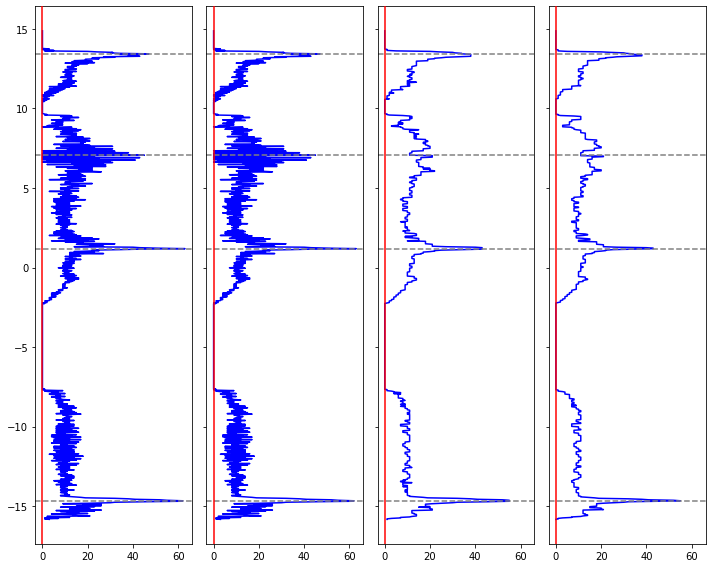

In [25]:
# central bit

kk = 1
hist, bins = np.histogram(spine[0], bins=np.linspace(kminis[0], kmaxes[0], 1000), density = False)
hist0 = hist.copy()
fhist = ndimage.median_filter(hist, size=5, mode='constant', cval=0)
mhistc = ndimage.minimum_filter1d(fhist, size=3, mode='constant', cval=0)

peaks, _ = signal.find_peaks(hist0, height=np.max(hist0)*.33, wlen=50, distance=125)
zeros = bins[peaks+1]
htop = np.max(zeros)
foo = np.argmin(np.abs(zeros))
hbot = zeros[foo]
hlength = htop - hbot
print(htop, hbot, hlength, sep='\t')

fig, ax = plt.subplots(1,4,figsize=(10,8), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel() ; i = 0
ax[i].plot(hist0, bins[1:],c='b'); i += 1
ax[i].plot(hist, bins[1:],c='b'); i += 1
ax[i].plot(fhist, bins[1:],c='b'); i += 1
ax[i].plot(mhistc, bins[1:],c='b')

for i in range(len(ax)):
    ax[i].axvline(0, c='r', zorder=9)
    for z in zeros:
        ax[i].axhline(z, c='gray', ls='--')

fig.tight_layout();

In [26]:
# lower arch height
atop = hbot
abot = np.median(legx)
alength = atop - abot
print(atop, abot, alength, sep='\t')

1.187277896182529	-14.857517560689633	16.044795456872162


2.564612523192196


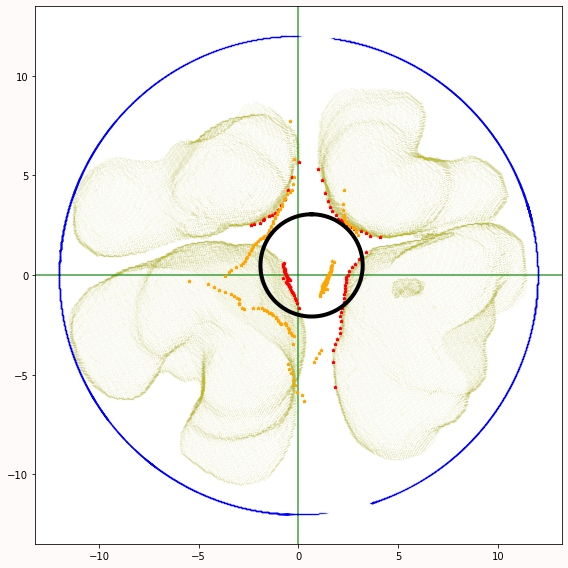

In [28]:
nhalfx = mcoords[:, mcoords[0] < np.mean([atop,abot])]
nhalfx = nhalfx - np.mean(nhalfx, axis=1).reshape(-1,1)

data = nhalfx[1:]
angles = np.angle(data[0] + data[1]*1j)
nvecs = data/np.linalg.norm(data.T, axis=1)

granularity = 100
bins = np.linspace(-np.pi, np.pi, granularity+1)
binning = np.digitize(angles, bins)

trace = np.zeros((granularity, 2))
for i in range(granularity):
    if np.sum(binning == i + 1) > 1:
        subdata = data[:, binning == i + 1]
        arg = np.argmin(np.sqrt(np.sum(subdata**2, axis=0)))
        trace[i] = subdata[:, arg]
trace = trace[np.all(trace, axis=1),:].T
radii = np.sqrt(np.sum(trace**2, axis=0))
mr = np.quantile(radii, 0.5)
mc = np.mean(trace, axis=1)
print(mr)

fs = 30

fig, ax = plt.subplots(1,1,figsize=(8,8), sharex=False, sharey=False, facecolor='snow')
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].scatter(nhalfx[1], nhalfx[2], s=.1, color='y', alpha=.2, marker='.');
ax[i].scatter(12*nvecs[0], 12*nvecs[1], s=.1, zorder=3, c='b', marker='.', alpha=.1)
ax[i].scatter(trace[0], trace[1], s=10, zorder=4, c='r', marker='*')
ax[i].scatter(ctrace[0], ctrace[1], s=10, zorder=4, c='orange', marker='*')
ax[i].plot(mr*circle[0] + mc[0], mr*circle[1]+mc[1], lw=4, c='k', zorder=5)

for i in range(len(ax)):
    ax[i].set_aspect('equal', 'datalim');
    ax[i].axvline(0, c='g',alpha=0.75)
    ax[i].axhline(0,c='g',alpha=0.75);
fig.tight_layout();

In [14]:
ctrace = trace - mc.reshape(-1,1)
cradii = np.sqrt(np.sum(ctrace**2, axis=0))
cmr = np.min(cradii)
cmr

1.304679771336192

In [51]:
c/a

0.9434199384362131

../hpcc/kernel/NewStuke_R1_T17/NewStuke_R1_T17_005_kernel.jpg


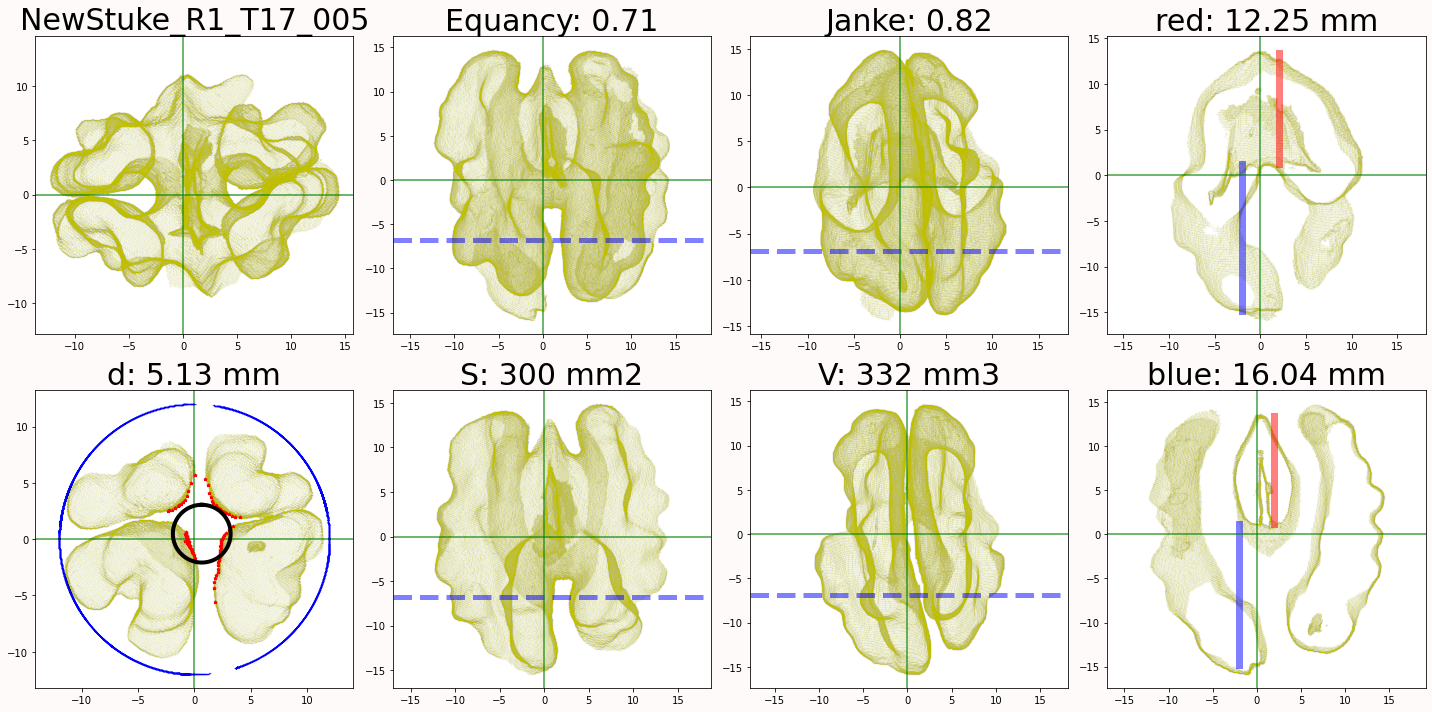

In [30]:
fs = 30

fig, ax = plt.subplots(2,4,figsize=(20,10), sharex=False, sharey=False, facecolor='snow')
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].scatter(phalfx[1], phalfx[2], s=.1, color='y', alpha=.2, marker='.')
ax[i].set_title(fname, fontsize=fs)
i += 1
ax[i].scatter(phalfz[1], phalfz[0], s=.1, color='y', alpha=.2, marker='.')
ax[i].axhline(np.mean([atop,abot]), c='b', lw=5, ls='--', alpha=.5)
ax[i].set_title('Equancy: {:.2f}'.format(c/a), fontsize=fs)
i += 1
ax[i].scatter(phalfy[2], phalfy[0], s=.1, color='y', alpha=.2, marker='.')
ax[i].axhline(np.mean([atop,abot]), c='b', lw=5, ls='--', alpha=.5)
ax[i].set_title('Janke: {:.2f}'.format(janke), fontsize=fs)
i += 1
ax[i].scatter(halfy[2], halfy[0], s=.1, color='y', alpha=.2, marker='.')
ax[i].plot([2,2], [htop, hbot], lw=7, c='r', alpha=.5)
ax[i].plot([-2,-2], [atop, abot], lw=7, c='b', alpha=0.5)
ax[i].set_title('red: {:.2f} mm'.format(hlength), fontsize=fs)
i += 1

######

ax[i].scatter(nhalfx[1], nhalfx[2], s=.1, color='y', alpha=.2, marker='.')
ax[i].scatter(12*nvecs[0], 12*nvecs[1], s=.1, zorder=3, c='b', marker='.', alpha=.1)
ax[i].scatter(trace[0], trace[1], s=10, zorder=4, c='r', marker='*')
ax[i].plot(mr*circle[0] + mc[0], mr*circle[1]+mc[1], lw=4, c='k', zorder=5)
ax[i].set_title('d: {:.2f} mm'.format(mr*2), fontsize=fs)
i += 1
ax[i].scatter(nhalfz[1], nhalfz[0], s=.1, color='y', alpha=.2, marker='.')
ax[i].axhline(np.mean([atop,abot]), c='b', lw=5, ls='--', alpha=.5)
ax[i].set_title('S: {:.0f} mm2'.format(2*np.pi*mr*(mr + alength)), fontsize=fs)
i += 1
ax[i].scatter(nhalfy[2], nhalfy[0], s=.1, color='y', alpha=.2, marker='.')
ax[i].axhline(np.mean([atop,abot]), c='b', lw=5, ls='--', alpha=.5)
ax[i].set_title('V: {:.0f} mm3'.format(np.pi*mr**2*alength), fontsize=fs)
i += 1
ax[i].scatter(halfz[1], halfz[0], s=.1, color='y', alpha=.2, marker='.')
ax[i].plot([2,2], [htop, hbot], lw=7, c='r', alpha=.5)
ax[i].plot([-2,-2], [atop, abot], lw=7, c='b', alpha=0.5)
ax[i].set_title('blue: {:.2f} mm'.format(alength), fontsize=fs)
i += 1

for i in range(len(ax)):
    ax[i].set_aspect('equal', 'datalim');
    ax[i].axvline(0, c='g',alpha=0.75)
    ax[i].axhline(0,c='g',alpha=0.75);
fig.tight_layout();

filename = wdst + fname + '_kernel.jpg'
print(filename)
plt.savefig(filename, dpi=96, format='jpg', bbox_inches = 'tight', pil_kwargs={'optimize':True})